# Efficient portfolio with pymoo and pymoode

To see more about pymoode, check its [git_repository](https://github.com/mooscaliaproject/pymoode) or the [tutorial](https://towardsdatascience.com/pymoode-differential-evolution-in-python-78e4221e5cbe).

To see mode about pymoo, check its [full documentation](https://pymoo.org/index.html), which includes an example of the [efficient frontier using SMS-MOEA](https://pymoo.org/case_studies/portfolio_allocation.html).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.util.remote import Remote

from pymoo.core.problem import Problem
from pymoo.core.mutation import Mutation
from pymoo.core.repair import Repair
from pymoo.optimize import minimize
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoode.algorithms import GDE3
from pymoode.survival import RankAndCrowding

In [3]:
#Read file from pymoo
file = Remote.get_instance().load("examples", "portfolio_allocation.csv", to=None)
dataset = pd.read_csv(file, parse_dates=True, index_col="date")

In [4]:
dataset.head()

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
date,,,,,,,,,,,,,,,,,,,,
1989-12-29,NaN,0.117203,NaN,NaN,NaN,0.352438,3.9375,3.486070,1.752478,NaN,2.365775,NaN,NaN,1.766756,NaN,0.166287,NaN,0.110818,1.827968,NaN
1990-01-02,NaN,0.123853,NaN,NaN,NaN,0.364733,4.1250,3.660858,1.766686,NaN,2.398184,NaN,NaN,1.766756,NaN,0.173216,NaN,0.113209,1.835617,NaN
1990-01-03,NaN,0.124684,NaN,NaN,NaN,0.364050,4.0000,3.660858,1.780897,NaN,2.356516,NaN,NaN,1.749088,NaN,0.194001,NaN,0.113608,1.896803,NaN
1990-01-04,NaN,0.125100,NaN,NaN,NaN,0.362001,3.9375,3.641439,1.743005,NaN,2.403821,NaN,NaN,1.731422,NaN,0.190537,NaN,0.115402,1.904452,NaN
1990-01-05,NaN,0.125516,NaN,NaN,NaN,0.358586,3.8125,3.602595,1.705114,NaN,2.287973,NaN,NaN,1.722587,NaN,0.190537,NaN,0.114405,1.912100,NaN


In [5]:
dataset.tail()

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
date,,,,,,,,,,,,,,,,,,,,
2018-04-05,1027.810059,172.800003,159.339996,172.570007,1451.750000,13.43,10.02,87.809998,30.320000,38.000000,35.632843,17.469999,2.97,76.019997,14.52,72.120003,175.550003,35.730000,111.879997,59.139999
2018-04-06,1007.039978,168.380005,157.199997,167.520004,1405.229980,13.06,9.61,86.690002,29.629999,37.680000,35.130001,16.980000,2.88,74.870003,13.97,70.489998,169.699997,35.169998,109.089996,58.340000
2018-04-09,1015.450012,170.050003,157.929993,169.869995,1406.079956,12.83,9.53,86.279999,29.870001,37.830002,35.169998,16.639999,2.82,74.870003,13.93,69.820000,170.339996,35.459999,110.400002,58.700001
2018-04-10,1031.640015,173.250000,165.039993,177.100006,1436.219971,13.05,9.98,86.449997,30.480000,39.070000,35.810001,16.820000,3.07,77.070000,14.78,71.720001,174.720001,35.950001,112.510002,59.410000
2018-04-11,1019.969971,172.440002,166.320007,175.360001,1427.050049,12.97,9.82,85.910004,29.900000,39.000000,35.250000,16.740000,3.30,77.430000,14.99,70.910004,172.360001,35.790001,110.620003,59.419998


In [6]:
#The original dataset goes back to 1990, of which the returns probably have small or no impact in expected returns
#Therefore I will select only adjusted prices after 2008
dataset = dataset.loc[dataset.index > '2008-01-01', :]

## Estimating returns based on past performance

**Simple returns:**\
$\displaystyle \frac{P_{t}}{P_{t-1}} = 1 + R_{t}$


**Log returns:**\
$\displaystyle r_{t} = \ln(1 + R_{t}) = \ln(\frac{P_{t}}{P_{t-1}})$

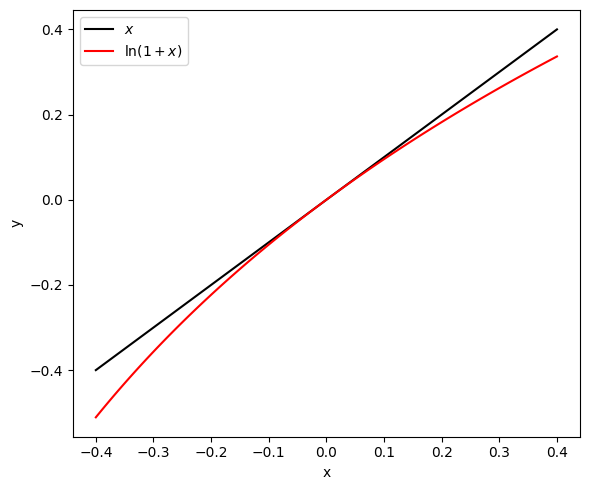

In [7]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)

fig.patch.set_facecolor('white')

x = np.linspace(-0.4, 0.4, 100)
ax.plot(x, x, color="black", label=r"$x$")
ax.plot(x, np.log(1 + x), color="red", label=r"$\ln(1 + x)$")

ax.set_xlabel(r"x")
ax.set_ylabel(r"y")

ax.legend()

fig.tight_layout()
plt.show()

In [8]:
#Number of trading days
N = 252

#Daily log returns assumed to follow a normal distribution
log_returns = (dataset / dataset.shift(1)).apply(np.log).dropna()
mean_log_returns = (log_returns).mean(axis=0) * N
#Covariance matrix of sum of N normally distributed elements
cov_log_matrix = log_returns.cov() * N

#Simple returns
simple_returns = (dataset / dataset.shift(1) - 1.0).dropna()
mean_simple_returns = simple_returns.mean(axis=0)
cov_simple_matrix = simple_returns.cov()

#Obtain variance of individual assets
individual_var = pd.Series({key: cov_simple_matrix.loc[key, key] for key in cov_log_matrix.index})
individual_sigma = individual_var.apply(np.sqrt)

Remember the annual covariance matrix $\Sigma$ is essentially different from ```mean_gross_returns.cov()*N``` as the annual returns do not correspond to the sum of daily gross returns, but their power to N.

In the other hand, log returns of a portfolio are not simply the weighted average log returns of its constituents.

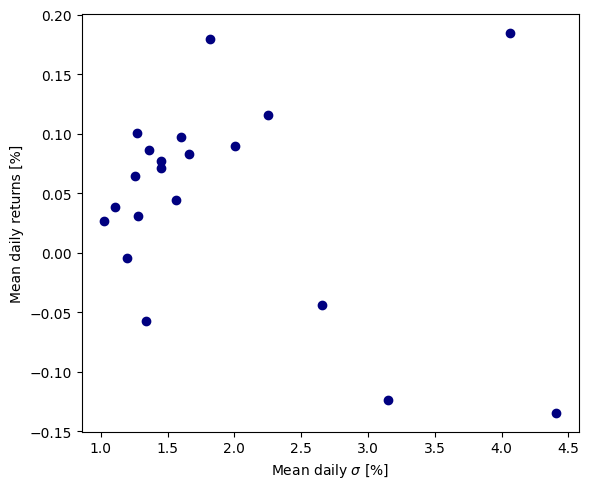

In [9]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)

ax.scatter(100 * individual_sigma, 100 * mean_simple_returns, color="navy", label="Individual Assets")

ax.set_xlabel(r"Mean daily $\sigma$ [%]")
ax.set_ylabel("Mean daily returns [%]")

fig.tight_layout()
plt.show()

## Multi-objective problem

$\displaystyle \mu_{P} = \sum_{i=1}^{N} w_{i} \mu_{i} = \boldsymbol{w}^T\boldsymbol{\mu}$

$\displaystyle \sigma_{P}^2 = \sum_{i=1}^{N} \sum_{j=1}^{N} w_{i} w_{j} \sigma_{i, j} = \boldsymbol{w}^T\boldsymbol{\Sigma}\boldsymbol{w}$

**Sharpe's ratio**:

$\displaystyle \frac{\mu_{P} - \mu_{f}}{\sigma_{P}}$

In [10]:
#Declare mu and sigma
mu = mean_simple_returns.values
sigma = cov_simple_matrix.values

\begin{align*}
\text{minimize} \;\;\; & -\mu_{P}=-\sum_{i=1}^N w_i \mu_{i}\\
& \sigma_{P} = \sqrt{\sum_{i=1}^{N} \sum_{j=1}^{N} w_{i} w_{j} \sigma_{i, j}}\\\\
\text{subject to} \;\;\; & \sum_{i} w_i = 1\\
& 0 \leq w_i \leq 1 & \forall \; i \in 1, 2, ..., N
\end{align*}

In [11]:
class PortfolioProblem(Problem):

    def __init__(self, mu, sigma, risk_free_rate=0.02/252, **kwargs):
        super().__init__(n_var=mu.shape[0], n_obj=2, xl=0.0, xu=1.0, n_ieq_constr=1, **kwargs)
        self.mu = mu
        self.sigma = sigma
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, X, out, *args, **kwargs):
        
        #Remember each line in X corresponds to an individual, with w in the columns
        exp_return = X.dot(self.mu).reshape([-1, 1])
        exp_sigma = np.sqrt(np.sum(X * X.dot(self.sigma), axis=1, keepdims=True))
        sharpe = (exp_return - self.risk_free_rate) / exp_sigma

        out["F"] = np.column_stack([exp_sigma, -exp_return])
        out["G"] = np.sum(X, axis=1, keepdims=True) - 1
        out["sharpe"] = sharpe

In [12]:
class Normalizer(Mutation):
    
    def _do(self, problem, X, **kwargs):
        X = X / np.sum(X, axis=1, keepdims=True)
        return X

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)

In [13]:
%%time

problem = PortfolioProblem(mu, sigma, 0.02/252)
normalizer = Normalizer()

np.random.seed(12)
X0 = np.random.rand(100, len(mu))
X0 = normalizer._do(problem, X0)

res = minimize(
    problem,
    GDE3(
        100, CR=0.9,
        survival=RankAndCrowding(crowding_func="pcd"),
        pm=normalizer,
        sampling=X0
    ),
    ("n_gen", 250),
    seed=12
)

CPU times: total: 4.05 s
Wall time: 5.75 s


In [14]:
%%time

res_sms = minimize(
    problem,
    SMSEMOA(
        100,
        repair=PortfolioRepair(),
        sampling=X0
    ),
    ("n_gen", 250),
    seed=12
)

CPU times: total: 4.69 s
Wall time: 5.72 s


In [15]:
def evaluate_as_function(X, mu, sigma):
    risk_free_allocation = 1 - X.sum(axis=1)
    exp_return = X.dot(mu).reshape([-1, 1])
    exp_sigma = np.sqrt(np.sum(X * X.dot(sigma), axis=1, keepdims=True))
    return np.column_stack([exp_sigma, exp_return])

In [16]:
X_mc = np.random.rand(100000, len(mu))
X_mc = X_mc / np.sum(X_mc, axis=1, keepdims=True)
F_mc = evaluate_as_function(X_mc, mu, sigma)

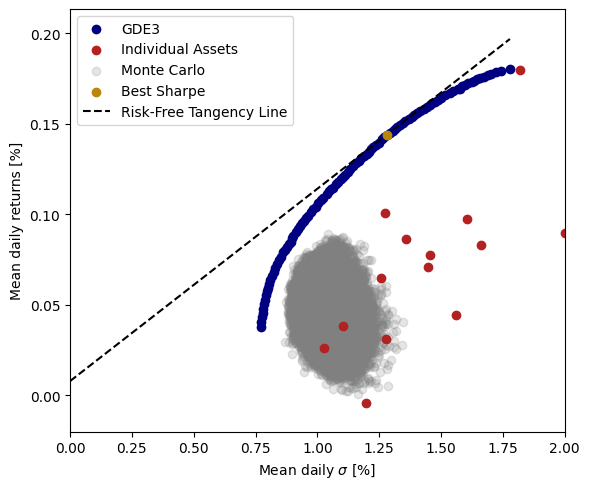

In [17]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)

fig.patch.set_facecolor('white')

ax.scatter(res.F[:, 0] * 100, -res.F[:, 1] * 100, color="navy", label="GDE3")
ax.scatter(100 * individual_sigma, 100 * mean_simple_returns, color="firebrick", label="Individual Assets", zorder=2)
ax.scatter(F_mc[:, 0] * 100, F_mc[:, 1] * 100, color="grey", alpha=0.2, label="Monte Carlo", zorder=0)

argmax_sharpe = res.opt.get("sharpe").argmax()
best_sharpe = res.opt.get("sharpe").max()

ax.scatter(res.F[argmax_sharpe, 0] * 100, -res.F[argmax_sharpe, 1] * 100, color="darkgoldenrod", label="Best Sharpe", zorder=4)
ax.plot([0, 100 * res.F[:, 0].max()],
        [100 * problem.risk_free_rate, 100 * problem.risk_free_rate + 100 * best_sharpe * res.F[:, 0].max()],
        color="black", linestyle="--", zorder=3, label="Risk-Free Tangency Line")

ax.set_xlim([0, 2.0])
ax.set_ylim([-0.02, None])

ax.legend()
ax.set_xlabel(r"Mean daily $\sigma$ [%]")
ax.set_ylabel("Mean daily returns [%]")

fig.tight_layout()
plt.show()

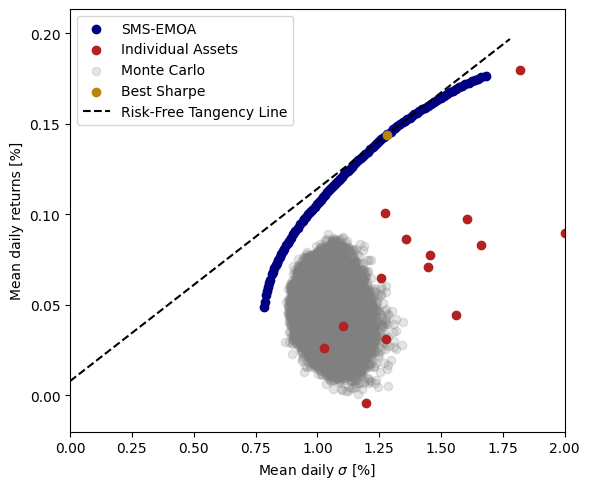

In [18]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)

fig.patch.set_facecolor('white')

ax.scatter(res_sms.F[:, 0] * 100, -res_sms.F[:, 1] * 100, color="navy", label="SMS-EMOA")
ax.scatter(100 * individual_sigma, 100 * mean_simple_returns, color="firebrick", label="Individual Assets", zorder=2)
ax.scatter(F_mc[:, 0] * 100, F_mc[:, 1] * 100, color="grey", alpha=0.2, label="Monte Carlo", zorder=0)

argmax_sharpe = res.opt.get("sharpe").argmax()
best_sharpe = res.opt.get("sharpe").max()

ax.scatter(res.F[argmax_sharpe, 0] * 100, -res.F[argmax_sharpe, 1] * 100, color="darkgoldenrod", label="Best Sharpe", zorder=4)
ax.plot([0, 100 * res.F[:, 0].max()],
        [100 * problem.risk_free_rate, 100 * problem.risk_free_rate + 100 * best_sharpe * res.F[:, 0].max()],
        color="black", linestyle="--", zorder=3, label="Risk-Free Tangency Line")

ax.set_xlim([0, 2.0])
ax.set_ylim([-0.02, None])

ax.legend()
ax.set_xlabel(r"Mean daily $\sigma$ [%]")
ax.set_ylabel("Mean daily returns [%]")

fig.tight_layout()
plt.show()

In [19]:
tickers = np.array(dataset.columns)
allocation = res.X[argmax_sharpe, :]
order = np.flip(np.argsort(allocation))

print("Best sharpe:")
for j in order:
    _t = tickers[j]
    _a = allocation[j] * 100
    print(f"{_t}: {_a:.2f}%")

Best sharpe:
AMZN: 48.67%
MA: 19.63%
BBY: 14.58%
JPM: 11.27%
AMD: 5.31%
BAC: 0.40%
GOOG: 0.09%
SBUX: 0.01%
SHLD: 0.01%
XOM: 0.01%
WMT: 0.01%
T: 0.00%
GM: 0.00%
GE: 0.00%
RRC: 0.00%
AAPL: 0.00%
UAA: 0.00%
BABA: 0.00%
PFE: 0.00%
FB: 0.00%


In [20]:
lowest_variance = np.argmin(res.F[:, 0])
allocation = res.X[lowest_variance, :]
order = np.flip(np.argsort(allocation))

print("Lowest variance:")
for j in order:
    _t = tickers[j]
    _a = allocation[j] * 100
    print(f"{_t}: {_a:.2f}%")

Lowest variance:
T: 29.80%
PFE: 21.13%
WMT: 13.58%
XOM: 11.21%
SBUX: 11.02%
AAPL: 4.65%
BABA: 2.08%
GM: 1.68%
AMZN: 1.60%
BBY: 0.92%
FB: 0.57%
MA: 0.42%
GE: 0.39%
GOOG: 0.32%
RRC: 0.31%
UAA: 0.19%
JPM: 0.12%
BAC: 0.00%
SHLD: 0.00%
AMD: 0.00%


In [21]:
best_returns = np.argmin(res.F[:, 1])
allocation = res.X[best_returns, :]
order = np.flip(np.argsort(allocation))

print("Best returns:")
for j in order:
    _t = tickers[j]
    _a = allocation[j] * 100
    print(f"{_t}: {_a:.2f}%")

Best returns:
AMZN: 79.50%
AMD: 20.27%
BBY: 0.10%
MA: 0.04%
UAA: 0.03%
GE: 0.03%
BAC: 0.01%
AAPL: 0.00%
JPM: 0.00%
BABA: 0.00%
GM: 0.00%
FB: 0.00%
SHLD: 0.00%
XOM: 0.00%
GOOG: 0.00%
SBUX: 0.00%
T: 0.00%
PFE: 0.00%
RRC: 0.00%
WMT: 0.00%


## Long-short

In [22]:
class LongShortPortfolioProblem(Problem):

    def __init__(self, mu, sigma, risk_free_rate=0.02/252, max_leverage=0.5, **kwargs):
        super().__init__(n_var=mu.shape[0], n_obj=2, xl=-max_leverage, xu=1.0, n_ieq_constr=2, **kwargs)
        self.mu = mu
        self.sigma = sigma
        self.risk_free_rate = risk_free_rate
        self.max_leverage = max_leverage

    def _evaluate(self, X, out, *args, **kwargs):
        
        exp_return = X.dot(self.mu).reshape([-1, 1])
        exp_variance = np.sum(X * X.dot(self.sigma), axis=1, keepdims=True)
        sharpe = (exp_return - self.risk_free_rate) / np.sqrt(exp_variance)
        X_neg = np.minimum(X, 0.0)

        out["F"] = np.column_stack([exp_variance, -exp_return])
        out["G"] = np.column_stack(
            [np.sum(X, axis=1, keepdims=True) - 1, np.sum(-X_neg, axis=1, keepdims=True) - self.max_leverage]
        )
        out["sharpe"] = sharpe

In [23]:
class LongShortNormalizer(Mutation):
    
    def _do(self, problem, X, **kwargs):
        
        X_neg = np.minimum(X, 0.0)
        violated_leverage = np.sum(-X_neg, axis=1) > problem.max_leverage
        
        if np.any(violated_leverage):
            X_neg[violated_leverage] = (
                X_neg[violated_leverage]
                / np.sum(abs(X_neg[violated_leverage]), axis=1, keepdims=True)
            ) * problem.max_leverage
        
        X = np.maximum(X, X_neg)
        X = X / np.sum(X, axis=1, keepdims=True)
        
        return X

In [24]:
problem = LongShortPortfolioProblem(mu, sigma, 0.02/252)
normalizer = Normalizer()

np.random.seed(12)
X0 = np.random.rand(70, len(mu))
X0 = normalizer._do(problem, X0)

res_long_short = minimize(
    problem,
    GDE3(
        70, CR=0.9, variant=("DE/ranked/1/bin"),
        gamma=1e-2,
        survival=RankAndCrowding(crowding_func="pcd"),
        pm=normalizer,
        initialize=X0
    ),
    ("n_gen", 350),
    seed=12
)